In [1]:
##This is the same workflow as the previous attempt with GBC, just swapping out for an SVC model
##For the full workflow including EDA and such, check it out: 
##https://www.kaggle.com/code/rhilavine/titanic-attempt-full-workflow-gbc

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
palette=sns.color_palette('magma')
sns.set(palette=palette)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
##Import the data
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [4]:
##Plan of action for cleaning and feature engineering:
#1. Drop properties that aren't useful (Ticket) or lack too much data (Cabin)
#2. Fill in missing values
#3. Extract useful data from existing properties (Title from Name)
#4. Dicretize continuous variables (Age and Fare)
#5. Map integers onto non-int data
#6. Drop redundant properties

In [5]:
##1. Drop properties that aren't useful (Ticket) or lack too much data (Cabin)
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)

In [6]:
#Function to fill in continuous values via ML. In this case, I've used SVM here for funsies
from sklearn.svm import SVR, SVC, LinearSVC #Calling them all because I'll use them later
def svm_num(df,na_col): #pass in the dataset and either Age or Fare
    df=df.copy()
    
    num_df = df.select_dtypes(np.number) 
    val_cols = num_df.loc[:,num_df.isna().sum() == 0].columns
    
    y_train = num_df.loc[num_df[na_col].isna()==False,na_col] 
    X_train = num_df.loc[num_df[na_col].isna()==False,val_cols]
    X_test = num_df.loc[num_df[na_col].isna()==True,val_cols]
    
    svr = SVR()
    svr.fit(X_train,y_train)
    
    y_pred = svr.predict(X_test)
    
    df.loc[df[na_col].isna()==True,na_col] = y_pred
    
    return df

In [7]:
train=svm_num(train,'Age') #Use function to fill in age data in the train set

In [8]:
test=svm_num(test,'Age') #...and the test set

In [9]:
test=svm_num(test,'Fare') #And the missing fare value in the test set

In [10]:
#There are still two missing values for the port of embarcation in the training set. Let's just fill them in with the mode.
port = train.Embarked.dropna().mode()[0]
train['Embarked'] = train['Embarked'].fillna(port)

In [11]:
##3. Extract useful data from existing properties (Title from Name)
all_data=[train,test]
for dataset in all_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.')

In [12]:
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [13]:
##4. Discretize continuous variables (Age and Fare)
#Separate age into categories
all_data=[train,test]
for dataset in all_data:    
    dataset.loc[ dataset['Age'] <= 12, 'Age'] = 0 #Child
    dataset.loc[(dataset['Age'] > 12) & (dataset['Age'] <= 19), 'Age'] = 1 #Teenager
    dataset.loc[(dataset['Age'] > 19) & (dataset['Age'] <= 30), 'Age'] = 2 #Young adult
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 50), 'Age'] = 3 #Adult
    dataset.loc[(dataset['Age'] > 50), 'Age'] = 4 #Older adult
    dataset['Age']=dataset['Age'].astype(int)

In [14]:
#As with age, let's split the continous fare data into discrete categories
all_data=[train,test]
for dataset in all_data:    
    dataset.loc[ dataset['Fare'] <= 10, 'Fare'] = 0 #Low
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 25), 'Fare'] = 1 #Middle
    dataset.loc[(dataset['Fare'] > 25) & (dataset['Fare'] <= 80), 'Fare'] = 2 #High
    dataset.loc[(dataset['Fare'] > 80), 'Fare'] = 3 #Super high
    dataset['Fare']=dataset['Fare'].astype(int)

In [15]:
##5. Map integers onto non-int data. So that means Sex, Embarked, and Title.
#Start with the Sex column
all_data=[train,test]
for dataset in all_data: 
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

In [16]:
#Then Embarked...
all_data=[train,test]
for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [17]:
#And finally for Title, filling in those without a title with "0"
all_data=[train,test]
for dataset in all_data:
    dataset['Title'] = dataset['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}).astype(int)
    dataset['Title'] = dataset['Title'].fillna(0)

In [18]:
##6. Drop redundant properties. We don't need PassengerID or Name in the datasets anymore. 
#However, be sure to stick the test set's PassengerIDs elsewhere to tack it onto the submission file!
test_ids=test['PassengerId']

In [19]:
train = train.drop(['Name','PassengerId'], axis=1)
test = test.drop(['Name','PassengerId'], axis=1)

In [20]:
##Time for some ML!
from sklearn.model_selection import train_test_split
X=train.drop('Survived', axis=1)
y=train['Survived']

In [21]:
#Split into test/training sets for the purpose of initial evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [22]:
##A quick function to check out the performance of multiple models
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve
def report(model):
    preds = model.predict(X_test)
    print(classification_report(y_test,preds))

In [23]:
#SVC (see complete workflow to see model performances, CV, and hyperparamter tuning)
svc = SVC()
svc.fit(X_train,y_train)

SVC()

In [24]:
svc_model=SVC(C= 0.5, gamma='scale')
svc_model.fit(X_train,y_train)

SVC(C=0.5)

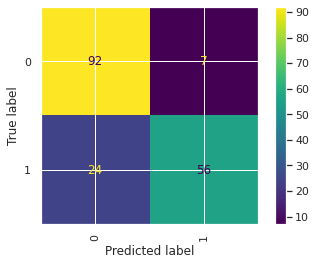

In [25]:
plot_confusion_matrix(svc_model,X_test,y_test, xticks_rotation='vertical')

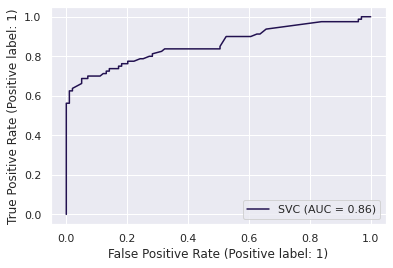

In [26]:
plot_roc_curve(svc_model, X_test, y_test)

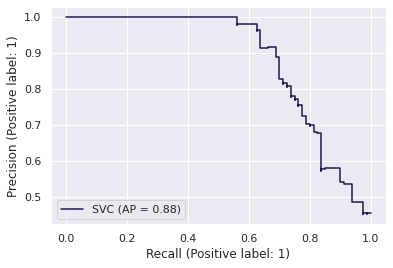

In [27]:
plot_precision_recall_curve(svc_model, X_test, y_test)

In [28]:
svc_model.fit(X,y)

SVC(C=0.5)

In [29]:
final_preds=svc_model.predict(test)
submission = pd.concat([test_ids,pd.Series(final_preds,name="Survived")],axis=1)
submission.to_csv("./submission.csv",index=False,header=True)